In [110]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

from os import listdir
from os.path import isfile, join

import re

In [111]:
def removeExtension(file_name):
    idx = -1
    for i, c in enumerate(file_name):
        if c == '.':
            idx = i
            break
    if idx >= 0:
        return file_name[:idx]
    return file_name

In [112]:
SUBMISSIONS_DIR = './submissions/'
MATCH_RESULTS_DIR = './match_results/'

In [113]:
files = sorted([f for f in listdir(SUBMISSIONS_DIR) if isfile(join(SUBMISSIONS_DIR, f)) and f[-1] != 'c'])
names = sorted([removeExtension(f) for f in files])

teams = list(zip(files, names))

In [134]:
match_results_df = pd.DataFrame(columns=['Team', 'Opponent', 'Wins', 'Losses', 'Ties', 'Invalid'])

In [135]:
def process_raw_outcome(outcome):
    return outcome.replace('\n', '')

for i in range(len(teams)):
    for j in range(i + 1, len(teams)):
        if i == j:
            continue
        
        file_a, name_a = teams[i]
        file_b, name_b = teams[j]
        
        # Get match results for team a vs team b
        match_data_file_name = name_a + '_vs_' + name_b + '.dat'
        try:
            match_data_file = open(join(MATCH_RESULTS_DIR, match_data_file_name), 'r')
        except FileNotFoundError:
            continue
        outcomes = [process_raw_outcome(l) for l in match_data_file]
        match_data_file.close()
        
        # Get DataFrame props
        num_rows, num_cols = match_results_df.shape
        
        # Insert row if doesn't exist or reset row
        index_a, index_b = -1, -1
        for k in range(num_rows):
            row = match_results_df.loc[k]
            if row.Team == name_a and row.Opponent == name_b:
                index_a = k
            if row.Team == name_b and row.Opponent == name_a:
                index_b = k
        if index_a == -1 and index_b == -1:
            index_a, index_b = num_rows, num_rows + 1
        elif index_a == -1:
            index_a = num_rows
        elif index_b == -1:
            index_b == num_rows
        
        win, loss, tied, invalid = 0, 0, 0, 0
        for outcome in outcomes:
            if outcome == name_a:
                win += 1
            elif outcome == name_b:
                loss += 1
            elif outcome == 'tied':
                tied += 1
            elif outcome == 'invalid':
                invalid += 1
            else:
                raise Error('Invalid match outcome')
        match_results_df.loc[index_a] = [name_a, name_b, win, loss, tied, invalid]
        match_results_df.loc[index_b] = [name_b, name_a, loss, win, tied, invalid]

In [139]:
match_results_df.shape

(1756, 6)

In [136]:
match_results_df.head()

,Team,Opponent,Wins,Losses,Ties,Invalid
0,PacBot_Kevin_Cao,baselineTeam2_Rachel_Li,9,3,0,3
1,baselineTeam2_Rachel_Li,PacBot_Kevin_Cao,3,9,0,3
2,PacBot_Kevin_Cao,baselineTeam2_Raghav_Anand,7,8,0,0
3,baselineTeam2_Raghav_Anand,PacBot_Kevin_Cao,8,7,0,0
4,PacBot_Kevin_Cao,cleverTeam_Dylan_Rowe,10,5,0,0


In [223]:
match_results_df[match_results_df['Invalid'] > 10].shape

(942, 9)

In [224]:
match_results_df[match_results_df['Team'] == 'myTeam_Laura_Smith'].head()

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
77,myTeam_Laura_Smith,PacBot_Kevin_Cao,1,0,0,14,1,1501.654164,1492.519507
165,myTeam_Laura_Smith,baselineTeam2_Rachel_Li,9,4,2,0,5,1510.445406,1491.166458
251,myTeam_Laura_Smith,baselineTeam2_Raghav_Anand,9,6,0,0,3,1516.501248,1526.669222
335,myTeam_Laura_Smith,cleverTeam_Dylan_Rowe,9,5,1,0,4,1523.351060,1482.486907
417,myTeam_Laura_Smith,contest_ANISH_SAHA,0,0,0,15,0,1522.845509,1499.048999


In [220]:
invalid_dict = dict(zip(names, [0] * len(names)))
for file, name in teams:
    invalids = match_results_df[(match_results_df['Invalid'] > 10) & (match_results_df['Team'] == name)].shape[0]
    invalid_dict[name] += invalids
    
INVALID_THRESH = 30
invalid_list = [name for name in names if invalid_dict[name] > INVALID_THRESH]
invalid_list

['contest_ANISH_SAHA',
 'contest_ANISH_SAHA_1',
 'myTeam2_SEAN_ADAM_MEDIN',
 'myTeam_Colin_K_Lai',
 'myTeam_SHARABESH_RAMESH',
 'myTeam_Shreya_Sahoo',
 'myTeam_Xing_Jin']

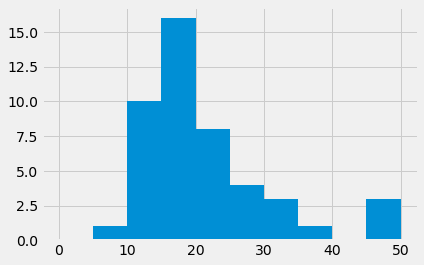

In [152]:
plt.hist(list(invalid_dict.values()), bins=np.arange(0, 55, 5))
plt.show()

# Elo

In [141]:
elo_dict = dict(zip(names, [1500] * len(names)))

In [143]:
match_results_df['margin'] = match_results_df.Wins - match_results_df.Losses

In [156]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin, K=20):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [157]:
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in match_results_df.itertuples():
    # Get key data from current row
    w = row.Team
    l = row.Opponent
    margin = row.margin
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w],
                              elo_dict[l], 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    
    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

In [184]:
win_elo = []
for w in w_elo:
    if isinstance(w, complex):
        win_elo.append(w.real)
    else:
        win_elo.append(w)
        
loss_elo = []
for l in l_elo:
    if isinstance(l, complex):
        loss_elo.append(l.real)
    else:
        loss_elo.append(l)

In [185]:
match_results_df['w_elo'] = win_elo
match_results_df['l_elo'] = loss_elo

In [186]:
match_results_df.tail(10)

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
1746,myTeam_Laura_Smith,myTeam_Swapnil_Das,0,0,0,15,0,1540.041755,1544.505952
1747,myTeam_Swapnil_Das,myTeam_Laura_Smith,0,0,0,15,0,1547.664383,1536.883325
1748,myTeam_Laura_Smith,myTeam_Swapnil_Das_1,0,0,0,15,0,1540.121772,1535.971192
1749,myTeam_Swapnil_Das_1,myTeam_Laura_Smith,0,0,0,15,0,1539.231298,1536.861666
1750,myTeam_SHARABESH_RAMESH,myTeam_Swapnil_Das,0,0,0,15,0,1505.987942,1543.899605
1751,myTeam_Swapnil_Das,myTeam_SHARABESH_RAMESH,0,0,0,15,0,1546.676304,1503.211242
1752,myTeam_SHARABESH_RAMESH,myTeam_Swapnil_Das_1,0,0,0,15,0,1506.858642,1535.583899
1753,myTeam_Swapnil_Das_1,myTeam_SHARABESH_RAMESH,0,0,0,15,0,1538.463269,1503.979271
1754,myTeam_Shreya_Sahoo,myTeam_Swapnil_Das,0,0,0,15,0,1490.689683,1542.728194
1755,myTeam_Swapnil_Das,myTeam_Shreya_Sahoo,0,0,0,15,0,1545.351282,1488.066596


In [187]:
final_elo_dict = dict(zip(names, [1500] * len(names)))

In [188]:
for row in match_results_df.itertuples():
    final_elo_dict[row.Team] = row.w_elo
    final_elo_dict[row.Opponent] = row.l_elo

In [222]:
rankings = zip(final_elo_dict.keys(), final_elo_dict.values())
rankings = [r for r in rankings if r[0] not in invalid_list]
rankings = sorted(list(rankings), key=lambda x: -x[1])
place = 1
for name, elo in rankings:
    print('%d.' %place, name, '(%.3f)' % elo)
    place += 1

1. myTeam3_4foodNum_ALI_KHALEEL_AHMED (1651.146)
2. myTeam3_5foodNum_ALI_KHALEEL_AHMED (1636.957)
3. myTeam3_ALI_KHALEEL_AHMED (1594.535)
4. myTeam2_ALI_KHALEEL_AHMED (1592.844)
5. myTeam3_ALI_KHALEEL_AHMED_6 (1586.211)
6. myTeam_Christina_Baek (1577.626)
7. myTeam2_ALI_KHALEEL_AHMED_1 (1569.566)
8. myTeam_Christina_Baek_1 (1564.816)
9. myTeam2_4foodNum_ALI_KHALEEL_AHMED (1555.013)
10. myTeam3_ALI_KHALEEL_AHMED_1 (1552.318)
11. myTeam_Swapnil_Das (1545.351)
12. myTeam3_ALI_KHALEEL_AHMED_3 (1540.821)
13. myTeam_Swapnil_Das_1 (1538.463)
14. myTeam_Laura_Smith (1536.862)
15. myTeam2_5foodNum_ALI_KHALEEL_AHMED (1530.577)
16. myTeam3_ALI_KHALEEL_AHMED_2 (1530.078)
17. myTeam_Benjamin_Carlson (1524.241)
18. PacBot_Kevin_Cao (1520.497)
19. myTeam3_ALI_KHALEEL_AHMED_4 (1517.816)
20. baselineTeam2_Raghav_Anand (1513.079)
21. myTeam_Colin_K_Lai_1 (1510.843)
22. coolTeam_SONTHAYA_VISUTHIKRAISEE (1510.274)
23. myTeam3_ALI_KHALEEL_AHMED_5 (1498.870)
24. myTeam_Joshua_Yurtsever (1492.371)
25. clever